In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt
from datetime import timedelta

In [2]:
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
start_date = "20230409"
end_date = "20230419"
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"

# Observations - comparison of two dates

## Open data for two dates

### SOS towers

In [3]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone(
    sos_df,
    'UTC',
    'US/Mountain'
)


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_50688/262988753.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src = src[src.time > '20230202'][src.time < '20230204']


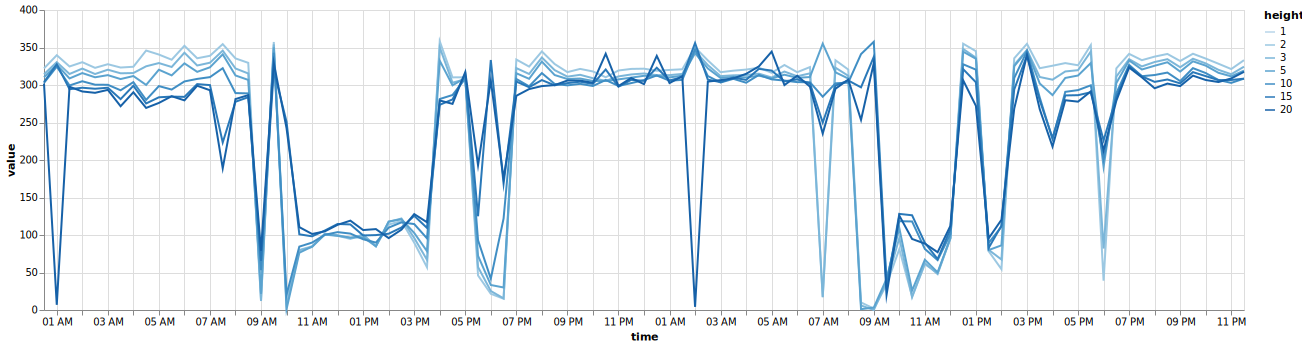

In [4]:
src = sos_df_localtime.query("measurement == 'wind direction'").query("tower == 'c'")
src = src[src.time > '20230202'][src.time < '20230204']
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
).properties(width=1200)

### Gothic Sail Tower data

In [5]:
# # Define the data codes for meteorological and turbulence data
# data_codes = [
#     'gucmetM1.b1',  # Example data code for meteorological data
#     'guc30ecorM1.b1'  # Example data code for turbulence data
# ]

# # Loop through each data code and download the data
# data_dict = {}
# for data_code in data_codes:
#     files = act.discovery.download_arm_data(
#         username,  # Replace with your ARM username
#         token,        # Replace with your ARM token
#         data_code,
#         start_date,
#         end_date,
#         output = os.path.join(data_dir, data_code)
#     )
#     print(files)
#     # Load the data into an ACT object and append to the list
#     ds = act.io.read_arm_netcdf(files)
#     data_dict[data_code] = ds

# gothic_met = data_dict[data_codes[0]]
# gothic_ec = data_dict[data_codes[1]]

In [6]:
def generate_date_range(start_date, end_date):
    # Parse the input dates
    start = dt.datetime.strptime(start_date, '%Y%m%d')
    end = dt.datetime.strptime(end_date, '%Y%m%d')
    
    # Generate the list of dates
    date_list = []
    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime('%Y%m%d'))
        current_date += timedelta(days=1)
    
    return date_list
dates = generate_date_range(start_date, end_date)
dates

['20230409',
 '20230410',
 '20230411',
 '20230412',
 '20230413',
 '20230414',
 '20230415',
 '20230416',
 '20230417',
 '20230418',
 '20230419']

In [7]:

files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, 'guc30ecorM1.b1', f"*{d}*.cdf"))
)
files = sorted(list((files).explode()))
sail_ecor_ds = xr.open_mfdataset(files)
sail_ecor_df = sail_ecor_ds.to_dataframe().reset_index()
sail_ecor_df_localtime = utils.modify_df_timezone(sail_ecor_df, 'UTC', 'US/Mountain')
sail_ecor_df_localtime = sail_ecor_df_localtime.query("bound == 0") ##???
sail_ecor_df_localtime

,time,bound,base_time,time_offset,time_bounds,mean_u,qc_mean_u,mean_v,qc_mean_v,mean_w,...,mean_spk_t,mean_spk_q,mean_spk_c,n_bad_sonic,n_bad_irga,n_bad_irga_light,mean_cooler,lat,lon,alt
0,2023-04-08 18:00:00,0,2023-04-09,2023-04-09 00:00:00,2023-04-09 00:00:00,0.3119,0,0.06288,0,-0.004526,...,282.200012,NaN,10.380,0.0,0.0,0.0,1.265,38.956158,-106.987854,2886.0
2,2023-04-08 18:30:00,0,2023-04-09,2023-04-09 00:30:00,2023-04-09 00:30:00,-0.6898,0,0.15810,0,-0.005108,...,NaN,NaN,10.380,0.0,0.0,0.0,1.254,38.956158,-106.987854,2886.0
4,2023-04-08 19:00:00,0,2023-04-09,2023-04-09 01:00:00,2023-04-09 01:00:00,-0.3908,0,-1.04100,0,0.013960,...,NaN,NaN,10.320,0.0,0.0,0.0,1.247,38.956158,-106.987854,2886.0
6,2023-04-08 19:30:00,0,2023-04-09,2023-04-09 01:30:00,2023-04-09 01:30:00,-0.8409,0,0.04252,0,0.003995,...,NaN,NaN,10.130,0.0,0.0,0.0,1.222,38.956158,-106.987854,2886.0
8,2023-04-08 20:00:00,0,2023-04-09,2023-04-09 02:00:00,2023-04-09 02:00:00,-0.2776,0,0.70870,0,-0.026300,...,NaN,NaN,9.607,0.0,0.0,0.0,1.204,38.956158,-106.987854,2886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,2023-04-19 15:30:00,0,2023-04-19,2023-04-19 21:30:00,2023-04-19 21:30:00,-4.6050,0,0.83110,0,-0.082890,...,283.299988,236.399994,10.460,39.0,0.0,0.0,1.167,38.956158,-106.987854,2886.0
1048,2023-04-19 16:00:00,0,2023-04-19,2023-04-19 22:00:00,2023-04-19 22:00:00,-3.3050,0,0.89820,0,-0.023110,...,281.700012,249.300003,10.470,4.0,0.0,0.0,1.171,38.956158,-106.987854,2886.0
1050,2023-04-19 16:30:00,0,2023-04-19,2023-04-19 22:30:00,2023-04-19 22:30:00,-3.5800,0,-0.39620,0,-0.026670,...,282.799988,250.100006,10.480,14.0,0.0,0.0,1.170,38.956158,-106.987854,2886.0
1052,2023-04-19 17:00:00,0,2023-04-19,2023-04-19 23:00:00,2023-04-19 23:00:00,-3.5490,0,-0.49130,0,0.016120,...,281.600006,252.199997,9.708,27.0,0.0,0.0,1.149,38.956158,-106.987854,2886.0


### Avery Picnic SPLASH Tower data

In [8]:
files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, "asfs/ASFS-50_Level2_SPLASH2021-2023/", f"sledseb.asfs50.level2.0.10min.{d}*.nc"))
).explode()
files = sorted(files)
files

['/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230409.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230410.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230411.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230412.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230413.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230414.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230415.000000.nc',
 '/Users/elis

In [9]:
splash_asfs_ds = xr.open_mfdataset(files)
splash_asfs_df = splash_asfs_ds.to_dataframe().reset_index()
splash_asfs_df_localtime = utils.modify_df_timezone(splash_asfs_df, 'UTC', 'US/Mountain')
splash_asfs_df_localtime

,time,freq,dfreq,base_time,time_offset,lat,lon,heading,altitude,zenith_true,...,bulk_dqer,bulk_Cd,bulk_Ch,bulk_Ce,bulk_Cdn_10m,bulk_Chn_10m,bulk_Cen_10m,bulk_Rr,bulk_Rt,bulk_Rq
0,2023-04-08 18:00:00,0,0,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
1,2023-04-08 18:00:00,0,1,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
2,2023-04-08 18:00:00,0,2,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
3,2023-04-08 18:00:00,0,3,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
4,2023-04-08 18:00:00,0,4,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702395,2023-04-19 17:50:00,59,55,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534
5702396,2023-04-19 17:50:00,59,56,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534
5702397,2023-04-19 17:50:00,59,57,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534
5702398,2023-04-19 17:50:00,59,58,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534


## Create Figure for Paper


In [10]:
surf_scaling_sos_df = sos_df_localtime[sos_df_localtime.variable.isin([
    'tke_3m_c',
    'spd_3m_c'
])].pivot_table(index='time', columns='variable', values='value').loc[start_date: end_date]
surf_scaling_sos_df = surf_scaling_sos_df.rename(columns = {
    'spd_3m_c': 'wind_speed',
    'tke_3m_c': 'TKE'
})
surf_scaling_sos_df

variable,wind_speed,TKE
time,,
2023-04-09 00:00:00,2.308832,0.413656
2023-04-09 00:30:00,2.152392,0.572132
2023-04-09 01:00:00,2.189626,0.380891
2023-04-09 01:30:00,1.387182,0.459206
2023-04-09 02:00:00,2.163823,0.325725
...,...,...
2023-04-19 21:30:00,3.187319,0.822570
2023-04-19 22:00:00,2.164419,0.637470
2023-04-19 22:30:00,3.927602,1.074988


In [11]:
surf_scaling_sail_df = sail_ecor_df_localtime.set_index('time')[['wind_spd']].join(
    0.5*(sail_ecor_df.set_index('time')[['var_u', 'var_v', 'var_w']]).sum(axis=1).rename('tke')
).drop_duplicates()
surf_scaling_sail_df = surf_scaling_sail_df.rename(columns = {
    'wind_spd': 'wind_speed',
    'tke': 'TKE'
})
surf_scaling_sail_df

,wind_speed,TKE
time,,
2023-04-08 18:00:00,0.3182,NaN
2023-04-08 18:30:00,0.7077,NaN
2023-04-08 19:00:00,1.1120,NaN
2023-04-08 19:30:00,0.8420,NaN
2023-04-08 20:00:00,0.7616,NaN
...,...,...
2023-04-19 15:30:00,4.6800,6.69090
2023-04-19 16:00:00,3.4250,3.00470
2023-04-19 16:30:00,3.6020,1.72435


In [12]:
splash_shrink = splash_asfs_df_localtime[[
    'wspd_vec_mean',
    'time',
    'sigU',
    'sigV',
    'sigW',
]].drop_duplicates()
surf_scaling_splash_df = splash_shrink.set_index('time')[['wspd_vec_mean']].join(
    (splash_shrink.set_index('time')[['sigU', 'sigV', 'sigW']]**2).sum(axis=1).rename('tke')
)
surf_scaling_splash_df = surf_scaling_splash_df.rename(columns = {
    'wspd_vec_mean': 'wind_speed',
    'tke': 'TKE'
})
surf_scaling_splash_df = surf_scaling_splash_df.resample('30min').mean()

In [13]:
combo_surf_scaling_df = pd.concat([
        surf_scaling_sos_df.assign(site='sos'),
        surf_scaling_sail_df.assign(site='sail'),
        surf_scaling_splash_df.assign(site='splash')
    ]).reset_index()
combo_surf_scaling_df

,time,wind_speed,TKE,site
0,2023-04-09 00:00:00,2.308832,0.413656,sos
1,2023-04-09 00:30:00,2.152392,0.572132,sos
2,2023-04-09 01:00:00,2.189626,0.380891,sos
3,2023-04-09 01:30:00,1.387182,0.459206,sos
4,2023-04-09 02:00:00,2.163823,0.325725,sos
...,...,...,...,...
1579,2023-04-19 15:30:00,6.465134,0.746187,splash
1580,2023-04-19 16:00:00,6.769738,1.604725,splash
1581,2023-04-19 16:30:00,6.544220,1.425893,splash
1582,2023-04-19 17:00:00,4.031650,0.487735,splash


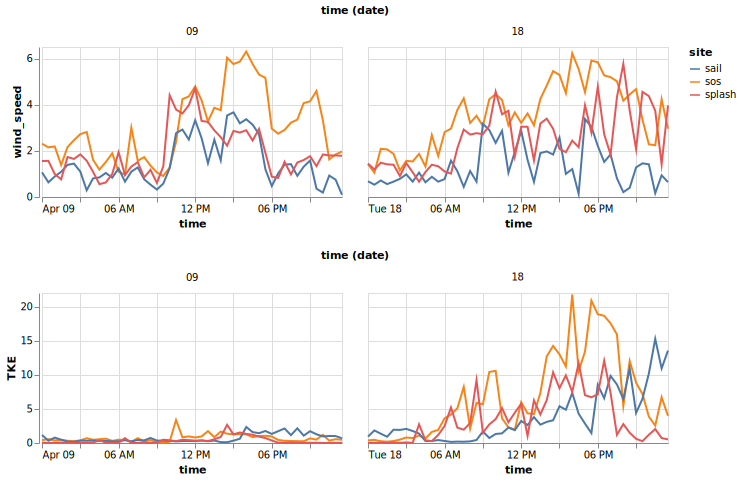

In [14]:
alt.Chart(
    combo_surf_scaling_df[
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 9))
        |
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 18))
    ]
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('wind_speed:Q'),
    alt.Color('site:N'),
    alt.Facet('date(time):O')
).resolve_scale(x='independent').properties(height=150) &\
alt.Chart(
    combo_surf_scaling_df[
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 9))
        |
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 18))
    ]
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('TKE:Q'),
    alt.Color('site:N'),
    alt.Facet('date(time):O')
).resolve_scale(x='independent').properties(height=150)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_50688/2430631574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['Vtke'] = src['TKE']**0.5


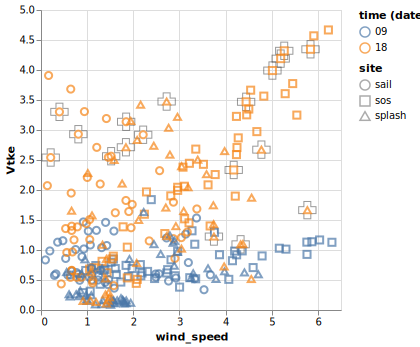

In [15]:
src = combo_surf_scaling_df[
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 9))
        |
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 18))
    ]
src['Vtke'] = src['TKE']**0.5
vortex_shedding_times_chart = alt.Chart(
    src.set_index('time').sort_index().loc['20230418 1800': '20230418 2059']
).mark_point(shape='cross', size=300, strokeWidth=1, color='black', opacity=0.4).encode(
    alt.X('wind_speed:Q'),
    alt.Y('Vtke:Q'),
)
two_days_times_chart = alt.Chart(
    src
).mark_point(size=50).encode(
    alt.X('wind_speed:Q'),
    alt.Y('Vtke:Q'),
    alt.Color('date(time):N'),
    alt.Shape('site:N')
)
two_days_per_site_chart = vortex_shedding_times_chart + two_days_times_chart
two_days_per_site_chart

# Observations - seasonal

## Open data for whole season

In [16]:
start_date = '20221130'
end_date = '20230509'

dates = generate_date_range(start_date, end_date)
dates[0], dates[-1], len(dates)

('20221130', '20230509', 161)

### Gothic Sail Tower data

In [17]:
# # Define the data codes for meteorological and turbulence data
# data_codes = [
#     'gucmetM1.b1',  # Example data code for meteorological data
#     'guc30ecorS3.b1'  # Example data code for turbulence data
# ]

# # Loop through each data code and download the data
# data_dict = {}
# for data_code in data_codes:
#     files = act.discovery.download_arm_data(
#         username,  # Replace with your ARM username
#         token,        # Replace with your ARM token
#         data_code,
#         start_date,
#         end_date,
#         output = os.path.join(data_dir, data_code)
#     )
#     print(files)
#     # Load the data into an ACT object and append to the list
#     ds = act.io.read_arm_netcdf(files)
#     data_dict[data_code] = ds

# gothic_met = data_dict[data_codes[0]]
# gothic_ec = data_dict[data_codes[1]]

In [18]:
files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, 'guc30ecorS3.b1', f"*{d}*.cdf"))
)

In [19]:
files = sorted(list((files).explode().dropna()))
sail_ecor_ds = xr.open_mfdataset(files)

In [20]:
sail_ecor_df = sail_ecor_ds[['var_u', 'var_v', 'var_w', 'wind_spd']].to_dataframe().reset_index()
sail_ecor_df_localtime = utils.modify_df_timezone(sail_ecor_df, 'UTC', 'US/Mountain')
sail_ecor_df_localtime = sail_ecor_df_localtime.set_index('time')
sail_ecor_df_localtime

,var_u,var_v,var_w,wind_spd
time,,,,
2022-11-29 17:00:00,2.6620,3.0730,0.11260,3.2020
2022-11-29 17:30:00,2.5180,1.2400,0.18060,4.1590
2022-11-29 18:00:00,2.0500,1.3280,0.14480,3.7520
2022-11-29 18:30:00,1.2320,1.5930,0.09134,1.4730
2022-11-29 19:00:00,0.2859,2.1540,0.03730,0.7446
...,...,...,...,...
2023-05-09 15:30:00,2.7880,2.4690,0.13430,3.2070
2023-05-09 16:00:00,2.0850,3.2970,0.19560,4.5460
2023-05-09 16:30:00,1.4430,0.8279,0.07900,2.6550


### Avery Picnic SPLASH Tower data

In [21]:
files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, "asfs/ASFS-50_Level2_SPLASH2021-2023/", f"sledseb.asfs50.level2.0.10min.{d}*.nc"))
).explode().dropna()
files = sorted(files)
files

['/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221130.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221201.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221202.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221203.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221204.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221205.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20221206.000000.nc',
 '/Users/elis

In [22]:
splash_asfs_ds = xr.open_mfdataset(files)

In [23]:
splash_asfs_ds = splash_asfs_ds[[
    'wspd_vec_mean',
    'time',
    'sigU',
    'sigV',
    'sigW',
]].resample(time='30min').mean()

In [24]:
splash_asfs_df = splash_asfs_ds.to_dataframe().reset_index()
splash_asfs_df_localtime = utils.modify_df_timezone(splash_asfs_df, 'UTC', 'US/Mountain')
splash_asfs_df_localtime = splash_asfs_df_localtime.rename(columns={ 'wspd_vec_mean': 'wind_speed',})
splash_asfs_df_localtime

,time,wind_speed,sigU,sigV,sigW
0,2022-11-29 17:00:00,4.543221,0.414720,0.397108,0.447469
1,2022-11-29 17:30:00,3.607009,0.239186,0.277151,0.317775
2,2022-11-29 18:00:00,1.952154,0.182028,0.306957,0.211905
3,2022-11-29 18:30:00,1.234980,0.129293,0.162647,0.173020
4,2022-11-29 19:00:00,1.803138,0.113087,0.132055,0.231247
...,...,...,...,...,...
7723,2023-05-09 15:30:00,3.099264,0.204873,0.146780,0.248597
7724,2023-05-09 16:00:00,2.550870,0.121606,0.111046,0.273773
7725,2023-05-09 16:30:00,3.129059,0.374115,0.396995,0.288181
7726,2023-05-09 17:00:00,2.226260,0.253840,0.291463,0.234804


In [25]:
splash_asfs_df_localtime['TKE'] = (splash_asfs_df_localtime[['sigU', 'sigV', 'sigW']]**2).sum(axis=1)

## Create figure for paper

In [26]:
sos_scaling_src = sos_df_localtime[sos_df_localtime.variable.isin(['tke_3m_c', 'spd_3m_c'])].pivot_table(values='value', index='time', columns='variable')
sos_scaling_src = sos_scaling_src.rename(columns={ 'spd_3m_c': 'wind_speed', 'tke_3m_c': 'TKE'})

In [27]:
sail_ecor_df_localtime['TKE'] = 0.5*(sail_ecor_df_localtime[['var_u', 'var_v', 'var_w']]).sum(axis=1).values
sail_ecor_df_localtime = sail_ecor_df_localtime.rename(columns={ 'wind_spd': 'wind_speed'})
sail_ecor_df_localtime

,var_u,var_v,var_w,wind_speed,TKE
time,,,,,
2022-11-29 17:00:00,2.6620,3.0730,0.11260,3.2020,2.923800
2022-11-29 17:30:00,2.5180,1.2400,0.18060,4.1590,1.969300
2022-11-29 18:00:00,2.0500,1.3280,0.14480,3.7520,1.761400
2022-11-29 18:30:00,1.2320,1.5930,0.09134,1.4730,1.458170
2022-11-29 19:00:00,0.2859,2.1540,0.03730,0.7446,1.238600
...,...,...,...,...,...
2023-05-09 15:30:00,2.7880,2.4690,0.13430,3.2070,2.695650
2023-05-09 16:00:00,2.0850,3.2970,0.19560,4.5460,2.788800
2023-05-09 16:30:00,1.4430,0.8279,0.07900,2.6550,1.174950


In [28]:
combo_surf_scaling_seasonal_df = pd.concat([
    sos_scaling_src[['wind_speed', 'TKE']].assign(site = 'sos'), 
    sail_ecor_df_localtime[['wind_speed', 'TKE']].assign(site = 'sail'), 
    splash_asfs_df_localtime.set_index('time')[['wind_speed', 'TKE']].assign(site = 'splash')
]).dropna()

## Open cross-valley/along-valley wind times

In [29]:
cross_valley_wind_times = pd.to_datetime(pd.read_csv('cross_valley_wind_times.csv')['0'])
along_valley_wind_times =  pd.to_datetime(pd.read_csv('along_valley_wind_times.csv')['0'])

fast_wind_times = pd.to_datetime(pd.read_csv('winds_ge10_times.csv')['time'])
slow_wind_times = pd.to_datetime(pd.read_csv('winds_le10_times.csv')['time'])

label data as cross/along-valley

In [30]:
combo_surf_scaling_seasonal_df_categorized = pd.concat([
    combo_surf_scaling_seasonal_df[combo_surf_scaling_seasonal_df.index.isin(cross_valley_wind_times)].assign(category = 'cross-valley'),
    combo_surf_scaling_seasonal_df[combo_surf_scaling_seasonal_df.index.isin(along_valley_wind_times)].assign(category = 'along-valley')
])

label data as fast/slow synoptic wind speeds

In [31]:
combo_surf_scaling_seasonal_df_categorized = pd.concat([
    combo_surf_scaling_seasonal_df_categorized[combo_surf_scaling_seasonal_df_categorized.index.isin(
        slow_wind_times
    )].assign(synoptic_wind_speed = '<= 10 m/s'),
    combo_surf_scaling_seasonal_df_categorized[combo_surf_scaling_seasonal_df_categorized.index.isin(
        fast_wind_times
    )].assign(synoptic_wind_speed = '> 10 m/s')
]).reset_index()

In [32]:
combo_surf_scaling_seasonal_df_categorized['spd_bin'] = pd.cut(
    combo_surf_scaling_seasonal_df_categorized['wind_speed'], 
    np.arange(0,11), 
    # labels = [f"{lo}-{hi}" for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
    labels = [float((lo + hi)/2) for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
).astype(float)

In [33]:
src = combo_surf_scaling_seasonal_df_categorized.copy()
src['Vtke'] = src['TKE']**0.5
src = src.query("spd_bin <= 8")


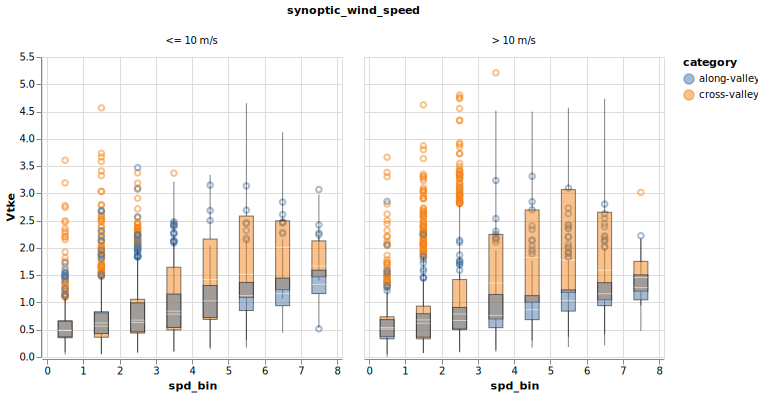

In [34]:
def plot(src):
    return alt.Chart(
        src
    ).mark_boxplot(
            opacity=0.5, box={'stroke': 'black'}
    ).encode(
        alt.X('spd_bin:Q').scale(domain=[0,8], nice=False),
        alt.Y('Vtke:Q'),
        alt.Color('category:N'),
        alt.Column('synoptic_wind_speed:N'),
    )
allseason_sos_chart = plot(src.query("spd_bin < 8"))
allseason_sos_chart

In [35]:
outlier_vtke_values = src.query("spd_bin < 4")
outlier_vtke_values_num05 = outlier_vtke_values[outlier_vtke_values['spd_bin'] == 0.5]
outlier_vtke_values_num1 = outlier_vtke_values[outlier_vtke_values['spd_bin'] == 1.5]
outlier_vtke_values_num2 = outlier_vtke_values[outlier_vtke_values['spd_bin'] == 2.5]

Q3 = outlier_vtke_values_num05['Vtke'].quantile(0.75)
Q1 = outlier_vtke_values_num05['Vtke'].quantile(0.25)
IQR = Q3 - Q1
sorted(
    outlier_vtke_values_num05[outlier_vtke_values_num05['Vtke'] > Q3 + 1.5 * IQR].time.dt.date.unique()
)

[datetime.date(2022, 12, 1),
 datetime.date(2022, 12, 2),
 datetime.date(2022, 12, 4),
 datetime.date(2022, 12, 5),
 datetime.date(2022, 12, 6),
 datetime.date(2022, 12, 9),
 datetime.date(2022, 12, 14),
 datetime.date(2022, 12, 31),
 datetime.date(2023, 1, 1),
 datetime.date(2023, 1, 5),
 datetime.date(2023, 1, 6),
 datetime.date(2023, 1, 9),
 datetime.date(2023, 1, 10),
 datetime.date(2023, 1, 14),
 datetime.date(2023, 1, 17),
 datetime.date(2023, 1, 21),
 datetime.date(2023, 1, 22),
 datetime.date(2023, 1, 26),
 datetime.date(2023, 1, 28),
 datetime.date(2023, 1, 30),
 datetime.date(2023, 2, 1),
 datetime.date(2023, 2, 2),
 datetime.date(2023, 2, 8),
 datetime.date(2023, 2, 14),
 datetime.date(2023, 2, 19),
 datetime.date(2023, 2, 20),
 datetime.date(2023, 2, 23),
 datetime.date(2023, 2, 25),
 datetime.date(2023, 2, 26),
 datetime.date(2023, 2, 27),
 datetime.date(2023, 3, 3),
 datetime.date(2023, 3, 4),
 datetime.date(2023, 3, 10),
 datetime.date(2023, 3, 13),
 datetime.date(2023, 

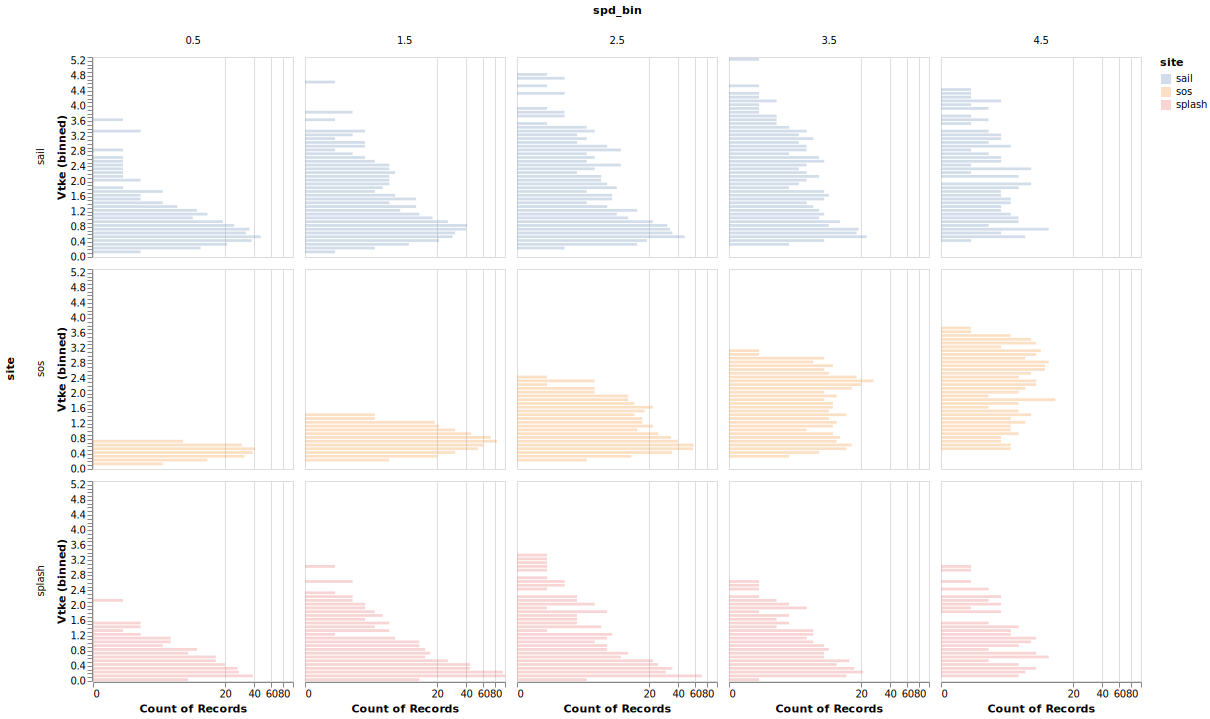

In [36]:
alt.Chart(
    src.query("synoptic_wind_speed == '> 10 m/s'").query("category == 'cross-valley'").query("spd_bin < 5.5")
).mark_bar(
    opacity=0.25
).encode(
    alt.Y('Vtke:Q').bin(step=0.1),
    alt.X('count():Q').scale(domain=[0,100], clamp=True, type='symlog'),
    alt.Color('site:N'),
    alt.Column('spd_bin:O', spacing=10),
    alt.Row('site:O', spacing=10),
).properties(width=200, height=200)

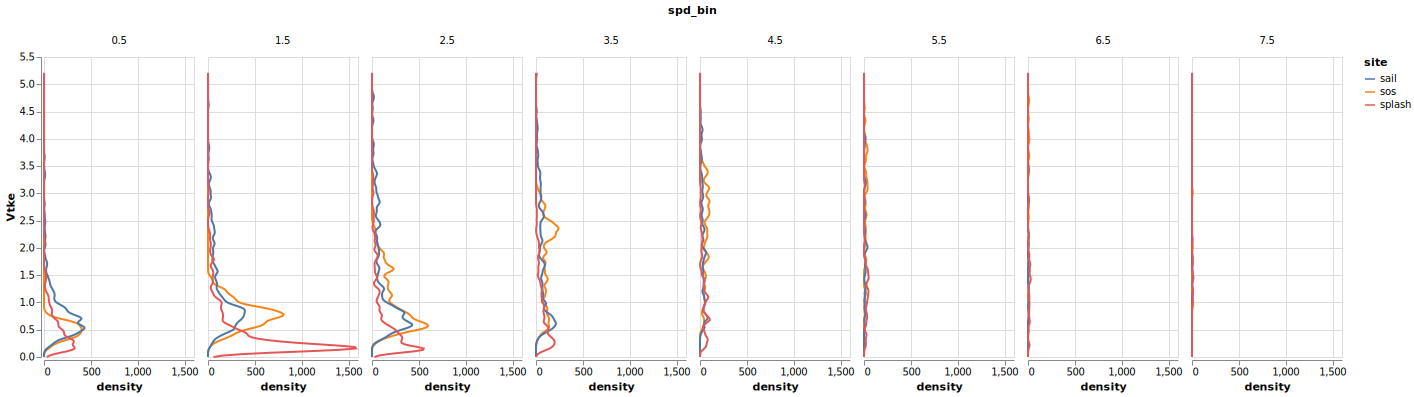

In [37]:
alt.Chart(
    src.query("synoptic_wind_speed == '> 10 m/s'").query("category == 'cross-valley'")
).transform_density(
    'Vtke',
    as_=['Vtke', 'density'],
    groupby = ['site', 'spd_bin'],
    bandwidth=0.05,
    counts=True
).mark_line().encode(
    alt.Y('Vtke:Q'),
    alt.X('density:Q'),
    alt.Column('spd_bin:O', spacing=10),
    alt.Color('site:N'),
    order='Vtke'
).properties(width=150)

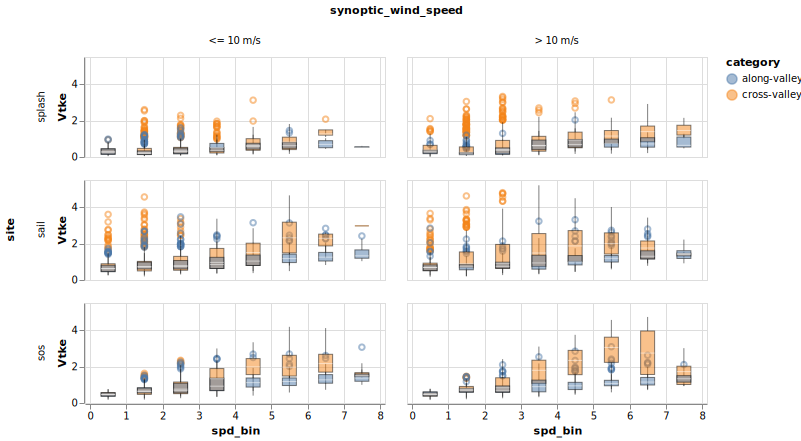

In [38]:
src = combo_surf_scaling_seasonal_df_categorized.copy()
src['Vtke'] = src['TKE']**0.5
allseason_3sites_chart_faceted = alt.Chart(
    src.query("spd_bin <= 8")
).mark_boxplot(
        opacity=0.5, box={'stroke': 'black'}
).encode(
    alt.X('spd_bin:Q').scale(domain=[0,8], nice=False),
    alt.Y('Vtke:Q'),
    alt.Color('category:N'),
    alt.Column('synoptic_wind_speed:N'),
    alt.Row('site:N', sort=['splash', 'sail', 'sos']),
).properties(height=100)
allseason_3sites_chart_faceted

In [61]:
tgrad_stable_times = list(pd.to_datetime(sos_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.05").time))
tgrad_unstable_times = list(pd.to_datetime(sos_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.05").time))
tgrad_neutral_times = list(pd.to_datetime(sos_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.05").query("value <= 0.05").time))
print(len(tgrad_stable_times))
print(len(tgrad_neutral_times))
print(len(tgrad_unstable_times))

6634
3252
851


In [40]:
src = combo_surf_scaling_seasonal_df_categorized.copy()
src['Vtke'] = src['TKE']**0.5
src = src.query("spd_bin <= 8")
src['spd bin per group'] = src.apply(
    lambda row: {
        'splash':   0.165 + row['spd_bin'] - 0.5,
        'sail':     0.495 + row['spd_bin'] - 0.5,
        'sos':      0.825 + row['spd_bin'] - 0.5,
    }.get(row['site']),
    axis=1
)

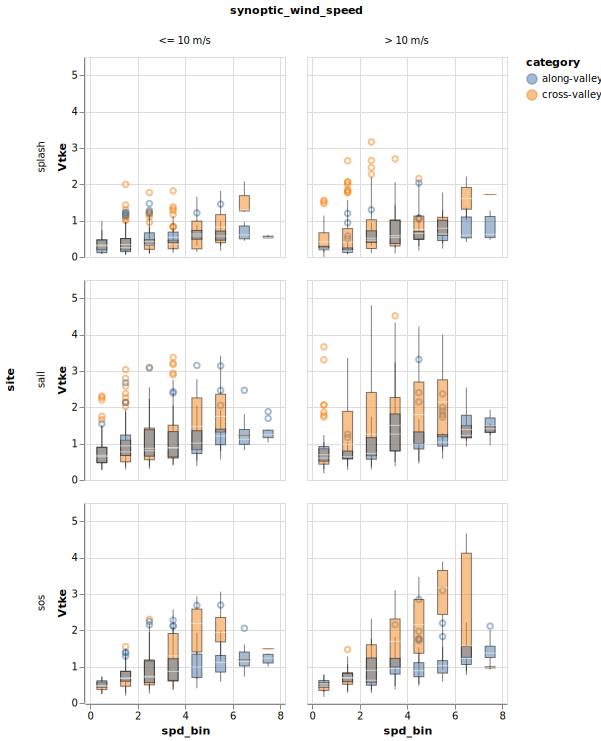

In [66]:
alt.Chart(
    src[src.time.isin(tgrad_neutral_times)]
).mark_boxplot(
        opacity=0.5, box={'stroke': 'black', 'size': 10}
).encode(
    alt.X('spd_bin:Q').scale(domain=[0,8], nice=False),
    alt.Y('Vtke:Q').scale(domain=[0,5.5]),
    alt.Color('category:N'),
    alt.Column('synoptic_wind_speed:N'),
    alt.Row('site:N', sort=['splash', 'sail', 'sos']),
).properties(width=200, height=200)

Identify what dates the outliers come from!

In [65]:
outliers_list = []
for bin in [0.5, 1.5, 2.5]:
    sail_bin = src.query("site == 'sail'").query(f"spd_bin == {bin}")
    Q1 = sail_bin['Vtke'].quantile(0.25)
    Q3 = sail_bin['Vtke'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sail_bin[(sail_bin['Vtke'] < lower_bound) | (sail_bin['Vtke'] > upper_bound)]
    outliers_list.append(outliers)
pd.concat(outliers_list).time.dt.date.value_counts().head(10)

time
2023-04-18    16
2022-12-05    12
2023-03-05    12
2023-04-19    11
2023-02-05    11
2023-03-08    11
2023-03-06    10
2023-03-07     7
2023-03-22     6
2023-02-20     6
Name: count, dtype: int64

In [66]:
outliers_list = []
for bin in [0.5, 1.5, 2.5]:
    sail_bin = src.query("site == 'splash'").query(f"spd_bin == {bin}")
    Q1 = sail_bin['Vtke'].quantile(0.25)
    Q3 = sail_bin['Vtke'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sail_bin[(sail_bin['Vtke'] < lower_bound) | (sail_bin['Vtke'] > upper_bound)]
    outliers_list.append(outliers)
pd.concat(outliers_list).time.dt.date.value_counts().head(10)

time
2023-04-18    16
2023-02-23    13
2023-03-05    12
2023-05-06    11
2023-03-06    10
2023-04-02    10
2023-04-19     9
2023-04-03     8
2022-12-08     6
2023-03-22     6
Name: count, dtype: int64

In [ ]:
src = sos_df_localtime[sos_df_localtime.variable.isin([
    'tke_3m_c', 'spd_3m_c',
    'tke_5m_c', 'spd_5m_c',
    'tke_10m_c', 'spd_10m_c',
    'tke_15m_c', 'spd_15m_c',
    'tke_20m_c', 'spd_20m_c',
])].pivot_table(values='value', index='time', columns='variable')
src['Vtke_3m_c'] = np.sqrt(src['tke_3m_c'])
src['Vtke_5m_c'] = np.sqrt(src['tke_5m_c'])
src['Vtke_10m_c'] = np.sqrt(src['tke_10m_c'])
src['Vtke_15m_c'] = np.sqrt(src['tke_15m_c'])
src['Vtke_20m_c'] = np.sqrt(src['tke_20m_c'])
src = src.loc['20221130': '20230509']
src = src.query("spd_3m_c < 10")
src = src.query("spd_20m_c < 10")
alt.Chart(
    src 
).mark_circle(opacity=0.5, size=2).encode(
    alt.X('spd_3m_c'),
    alt.Y('Vtke_3m_c')
) | alt.Chart(
    src.loc['20221130': '20230509']
).mark_circle(color='red', opacity=0.5, size=2).encode(
    alt.X('spd_20m_c'),
    alt.Y('Vtke_20m_c')
)

In [ ]:
alt.Chart(
    src.loc['20221130': '20230509']
).mark_boxplot(opacity=0.5, size=2).encode(
    alt.X('spd_3m_c').bin(step=0.5),
    alt.Y('Vtke_3m_c')
) + alt.Chart(
    src.loc['20221130': '20230509']
).mark_boxplot(color='red', opacity=0.5, size=2).encode(
    alt.X('spd_20m_c').bin(step=0.5),
    alt.Y('Vtke_20m_c')
)

In [ ]:
(two_days_per_site_chart | allseason_sos_chart).resolve_scale(
    color='independent',
    y='shared',
    x='shared'
)

In [ ]:
(two_days_per_site_chart | allseason_3sites_chart_faceted).resolve_scale(
    color='independent',
    x='shared'
)

In [ ]:
alt.Chart(
    combo_surf_scaling_seasonal_df_categorized.dropna().query("spd_bin <= 8")
).mark_point(size=20).encode(
    alt.X('spd_bin:Q'),
    alt.XOffset('site:N'),
    alt.Y('mean(TKE):Q'),
    alt.Shape('site:N'),
    alt.Color('category:N'),
    # alt.Column('site:N'),
)

In [ ]:
alt.Chart(
    combo_surf_scaling_seasonal_df_categorized.dropna().query("spd_bin <= 8")
).mark_boxplot(
    outliers=False, opacity=0.5, box={'stroke': 'black'}
).encode(
    alt.X('spd_bin:Q'),
    alt.Y('TKE:Q'),
    alt.Color('category:N'),
    alt.Row('site:N'),
).properties(height=100)